**Objective:** to detect most of the churned customers

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import math
import pickle

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# 1. Dataset

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/clf-telco_customer_churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
print(len(df[df['MonthlyCharges']==' ']))
print(len(df[df['TotalCharges']==' ']))

0
11


In [8]:
df[df['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


* no null vals in any col
* null vals as empty str → ['TotalCharges']
  * customer has not made any payment
* majority independent cols are categorical
* convert to float → ['TotalCharges']

In [9]:
# df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].replace(' ', '0.0')
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [10]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

In [11]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [12]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('customerID')

num_cols = df.select_dtypes(include='number').columns.tolist()

In [13]:
for col in cat_cols:
  print(col, df[col].unique())
  print('-'*50)

gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No internet 

imbalance check

In [14]:
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


# 2. EDA

## 2.1 cat cols

<Axes: xlabel='count', ylabel='Churn'>

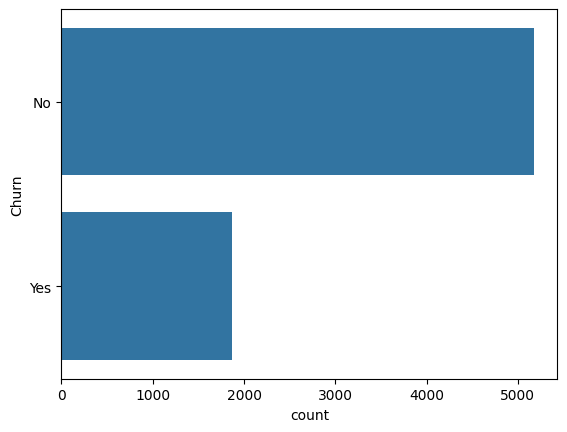

In [ ]:
sns.countplot(df['Churn'])

2.5x more non-churn dps than churn dps

In [ ]:
len(cat_cols), len(cat_cols)//3+1

(17, 6)

In [ ]:
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

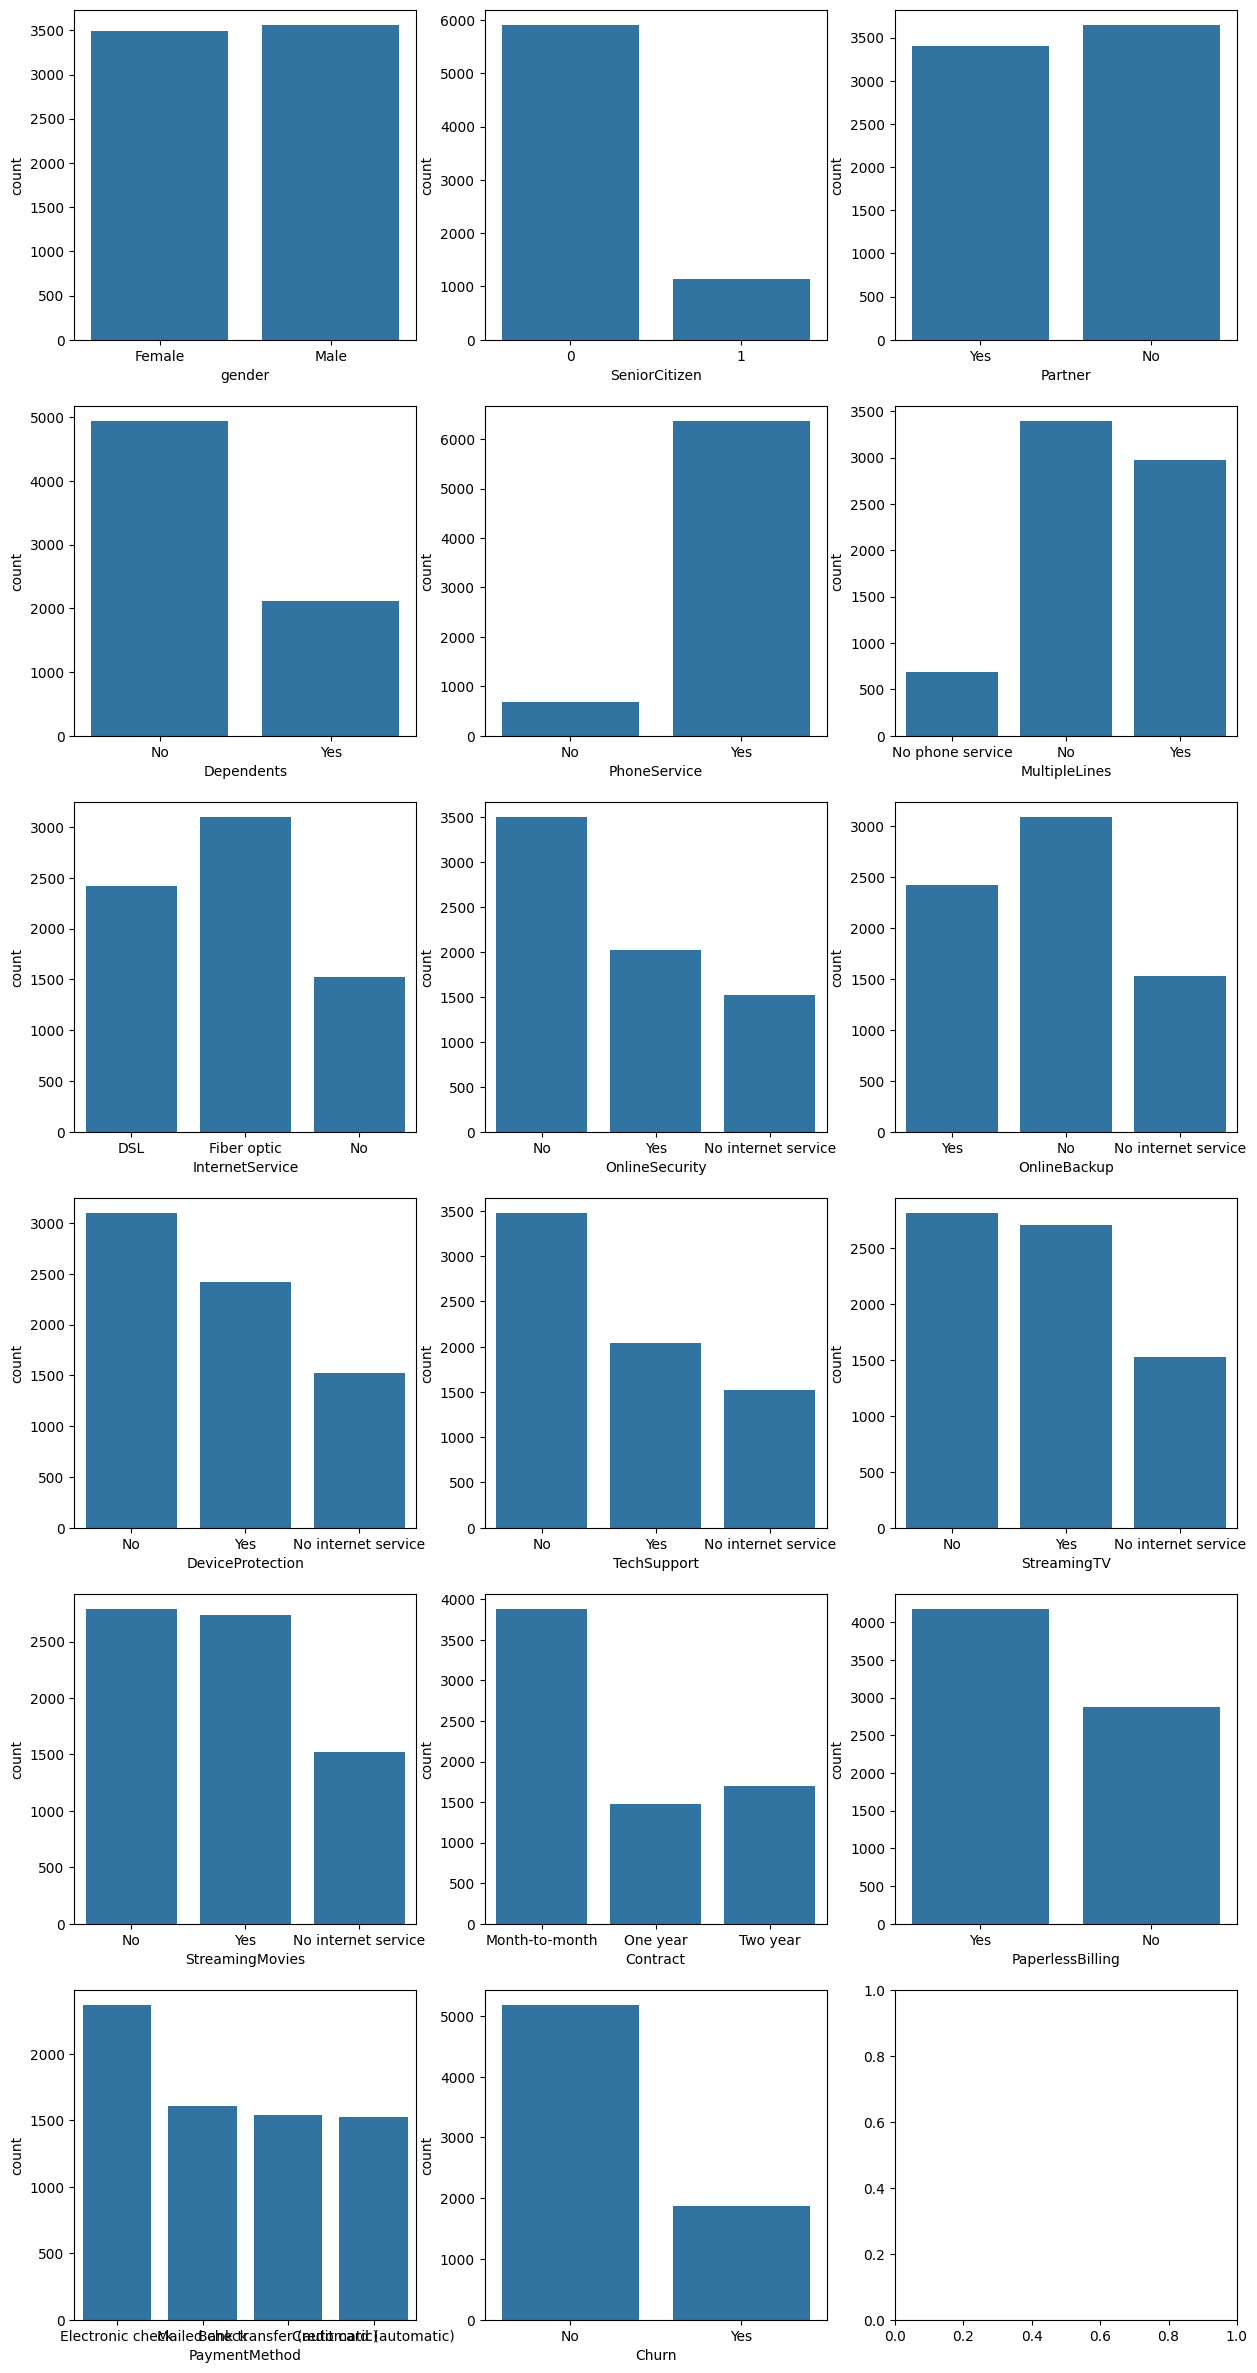

In [ ]:
fig, ax = plt.subplots(len(cat_cols)//3 + 1, 3, figsize=(15, 30))
ax = ax.flatten()

for i, col in enumerate(cat_cols):
  sns.countplot(x=col, data=df, ax=ax[i])

* gender ratio is equal
* ~10% senior citizens
* ~10% with no phone service

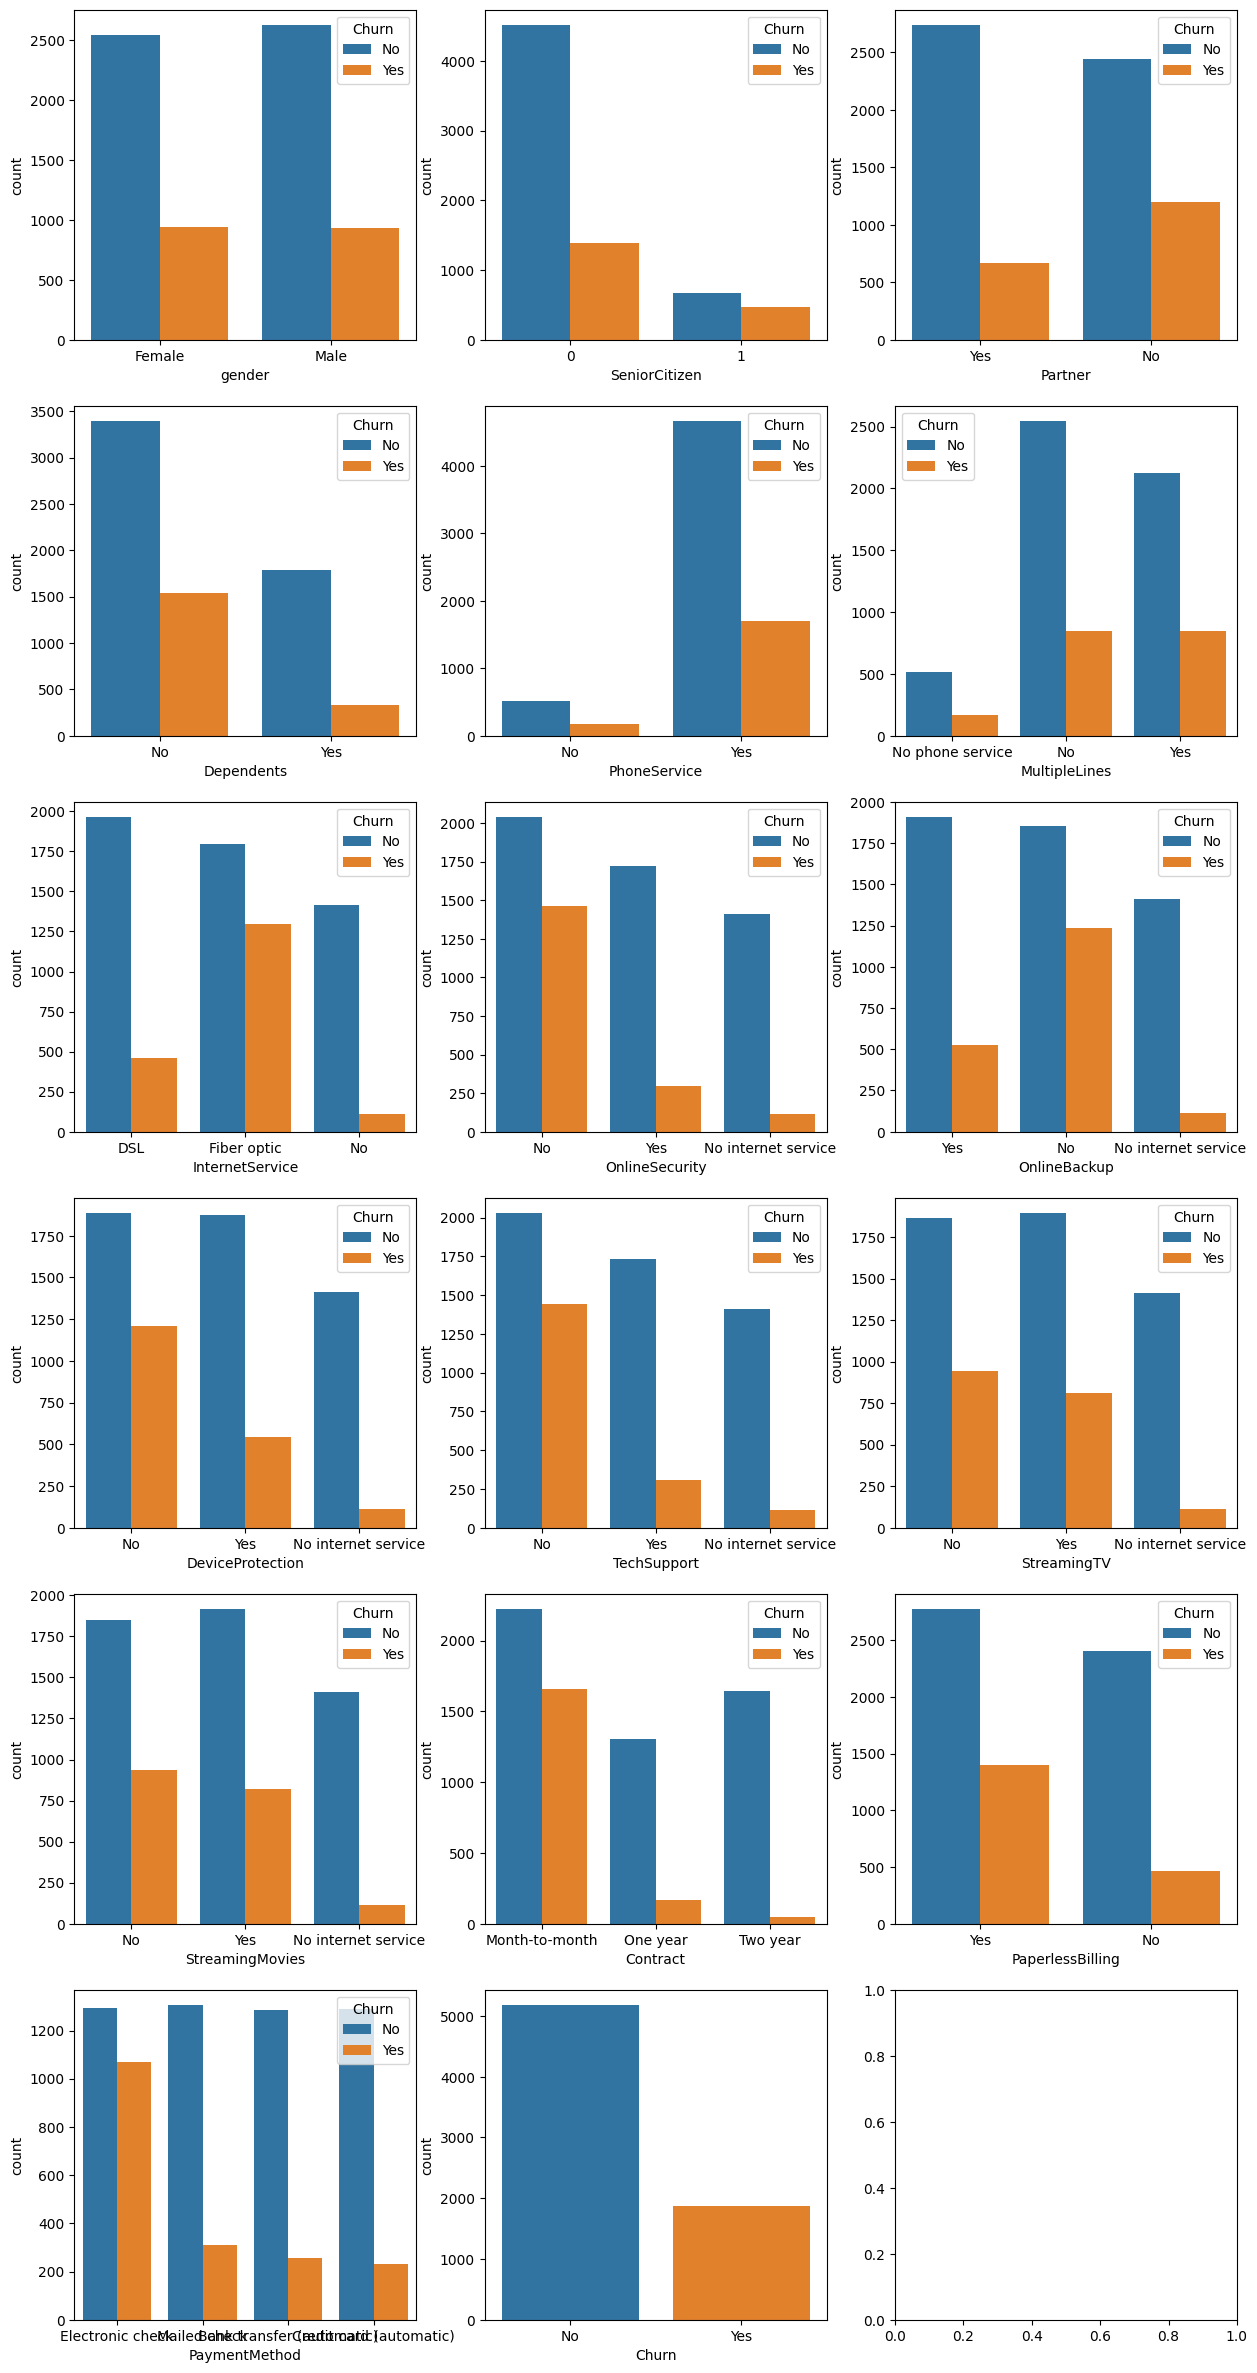

In [ ]:
fig, ax = plt.subplots(len(cat_cols)//3 + 1, 3, figsize=(15, 30))
ax = ax.flatten()

for i, col in enumerate(cat_cols):
  sns.countplot(x=col, data=df, hue='Churn', ax=ax[i])

In [ ]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

* ~80% senior citizens churn
* ~50% with no partners churn
* ~70% with fiber optic churn
* ~70% with no online security churn
* ~60% with no online backup churn
* ~60% with no device protection churn
* ~70% with no tech support churn
* < 10% with internet service churn
* ~70% with month-to-month contract churn
* ~80% with electronic check churn

## 2.2 num cols

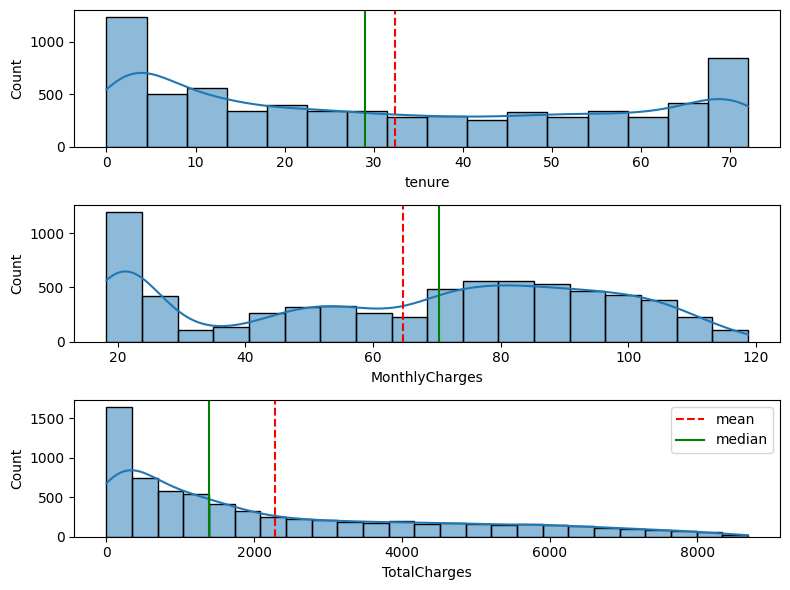

In [ ]:
fig, ax = plt.subplots(len(num_cols), 1, figsize=(8, 6))
ax = ax.flatten()

for i, col in enumerate(num_cols):
  sns.histplot(x=col, data=df, kde=True, ax=ax[i])

  mean = df[col].mean()
  median = df[col].median()
  ax[i].axvline(mean, color='red', linestyle='--', label='mean')
  ax[i].axvline(median, color='green', linestyle='-', label='median')

plt.legend()
plt.tight_layout()
plt.show()

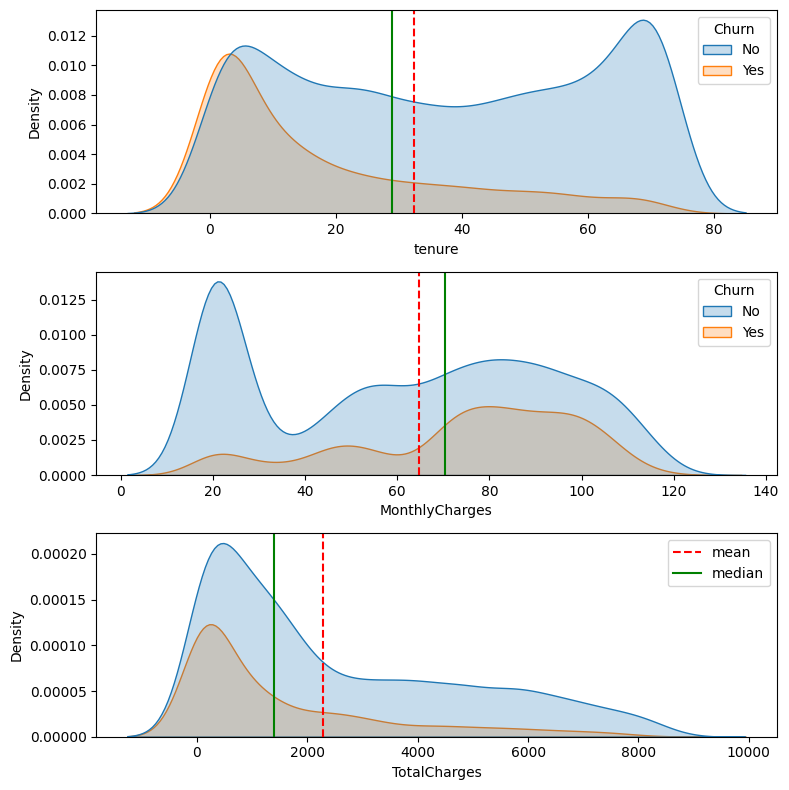

In [ ]:
fig, ax = plt.subplots(len(num_cols), 1, figsize=(8, 8))
ax = ax.flatten()

for i, col in enumerate(num_cols):
  sns.kdeplot(x=col, data=df, hue='Churn', fill=True, ax=ax[i])

  mean = df[col].mean()
  median = df[col].median()
  ax[i].axvline(mean, color='red', linestyle='--', label='mean')
  ax[i].axvline(median, color='green', linestyle='-', label='median')

plt.legend()
plt.tight_layout()
plt.show()

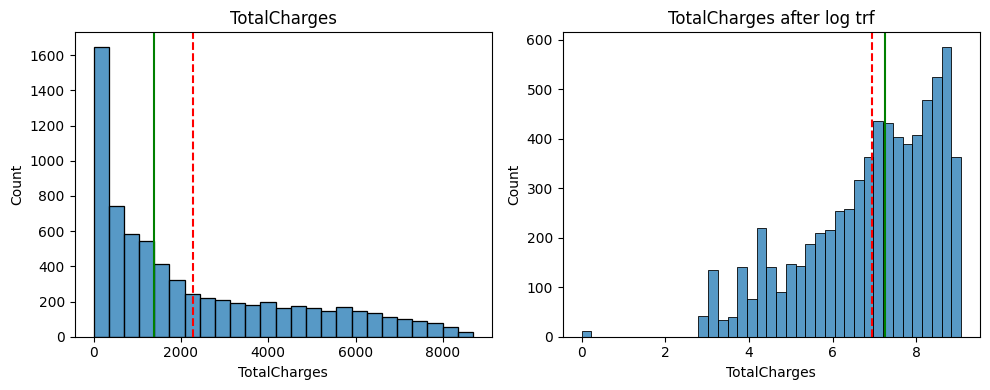

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax = ax.flatten()

sns.histplot(df['TotalCharges'], ax=ax[0])
ax[0].axvline(df['TotalCharges'].median(), color='green', linestyle='-')
ax[0].axvline(df['TotalCharges'].mean(), color='red', linestyle='--')
ax[0].set_title('TotalCharges')

total_log_trf = df['TotalCharges'].apply(np.log1p)
sns.histplot(total_log_trf, ax=ax[1])
ax[1].axvline(total_log_trf.median(), color='green', linestyle='-')
ax[1].axvline(total_log_trf.mean(), color='red', linestyle='--')
ax[1].set_title('TotalCharges after log trf')

plt.tight_layout()
plt.show()

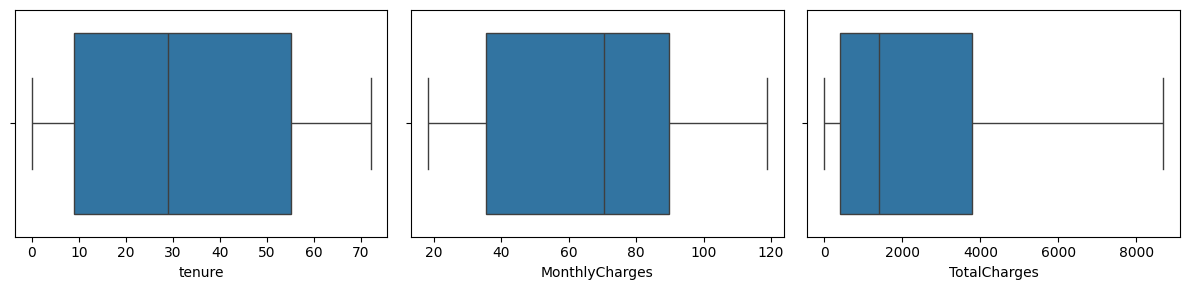

In [ ]:
Tfig, ax = plt.subplots(1, len(num_cols), figsize=(12, 3))
ax = ax.flatten()

for i, col in enumerate(num_cols):
  sns.boxplot(x=col, data=df, ax=ax[i])

plt.tight_layout()

<Axes: >

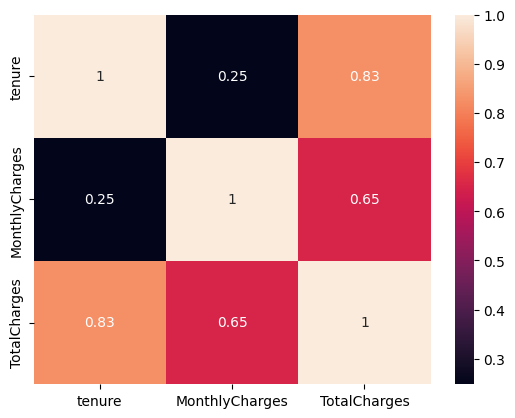

In [ ]:
sns.heatmap(df[num_cols].corr(), annot=True )

* high correlation between tenure and total charges

## 2.3 cat vs num cols

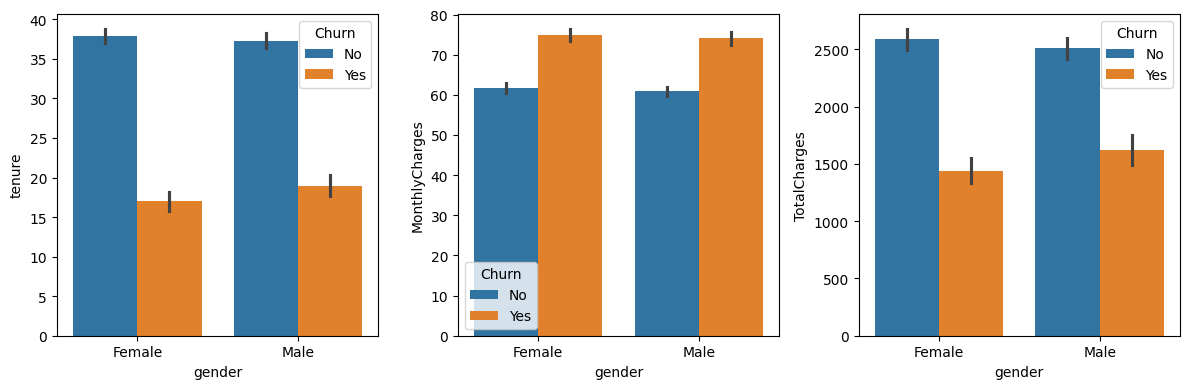

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for i, col in enumerate(num_cols):
  sns.barplot(x='gender', y=col, data=df, hue='Churn', ax=ax[i])

plt.tight_layout()

* churn ratio is higher for high MonthlyCharges

# 3. Preprocessing

In [17]:
cat_cols.remove('Churn')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [138]:
X, y = df.drop(columns=['Churn']), df['Churn']
X.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [139]:
y = y.replace({'Yes': 1, 'No': 0})
y.head()

<ipython-input-139-f0dafcb22233>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'Yes': 1, 'No': 0})


,Churn
0,0
1,0
2,1
3,0
4,1


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((5634, 20), (1409, 20))

In [141]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv("train_data.csv", index=False)

test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv("test_data.csv", index=False)

In [107]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

In [108]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

In [109]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape, X_test.shape

((5634, 46), (1409, 46))

upsampling

In [24]:
X_train_smote, y_train_smote = SMOTE().fit_resample(X_train, y_train)
len(X_train_smote)

8276

In [25]:
X_train_up, y_train_up = RandomOverSampler().fit_resample(X_train, y_train)
len(X_train_up)

8276

downsampling

In [26]:
X_train_down, y_train_down = RandomUnderSampler().fit_resample(X_train, y_train)
len(X_train_down)

2992

up-down sampling

In [27]:
X_train_updown, y_train_updown = RandomOverSampler(sampling_strategy=0.5).fit_resample(X_train, y_train)
X_train_updown, y_train_updown = RandomUnderSampler(sampling_strategy=0.5).fit_resample(X_train_updown, y_train_updown)
len(X_train_updown)

6207

# 4. Training

## model selection

In [ ]:
models = {
    "log_reg": LogisticRegression(),
    "dt": DecisionTreeClassifier(),
    "rf": RandomForestClassifier(),
    "svm": SVC()
}

In [ ]:
print('accuracy')
print('-'*20)
for name, model in models.items():
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
  print(f"{name}: {np.mean(scores):.2f}")

accuracy
--------------------
log_reg: 0.80
dt: 0.73
rf: 0.78
svm: 0.80


In [ ]:
print('accuracy after SMOTE')
print('-'*20)
for name, model in models.items():

  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
  print(f"{name}: {np.mean(scores):.2f}")

accuracy after SMOTE
--------------------
log_reg: 0.77
dt: 0.79
rf: 0.86
svm: 0.80


* random forest has the highest score

## hyper-parameter tuning

In [ ]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_samples': [0.25, 0.5, 0.75],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 10, 'max_samples': 0.25, 'n_estimators': 200}


In [ ]:
grid_search.best_score_

0.8544093436665353

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, max_samples=0.25, n_estimators=200)

## selected model

In [ ]:
rf = RandomForestClassifier(max_depth=10,max_samples=0.75, n_estimators=200)
rf_smote = RandomForestClassifier(max_samples=0.75, n_estimators=200)
rf_up = RandomForestClassifier(max_samples=0.75, n_estimators=200)
rf_down = RandomForestClassifier(max_samples=0.75, n_estimators=200)
rf_updown = RandomForestClassifier(max_samples=0.75, n_estimators=200)

rf.fit(X_train, y_train)
rf_smote.fit(X_train_smote, y_train_smote)
rf_up.fit(X_train_up, y_train_up)
rf_down.fit(X_train_down, y_train_down)
rf_updown.fit(X_train_updown, y_train_updown)

RandomForestClassifier(max_samples=0.75, n_estimators=200)

In [ ]:
models = {
    'rf': rf,
    'rf_smote': rf_smote,
    'rf_up': rf_up,
    'rf_down': rf_down,
    'rf_updown': rf_updown
}

# 5. Evaluation

In [ ]:
y_test.value_counts()

,count
Churn,
0,1036
1,373


In [ ]:
y_pred = rf.predict(X_test)
print(f"accuracy: {accuracy_score(y_test, y_pred):.2f}")

accuracy: 0.80


## classification report

In [ ]:
for model in models:
  print(str(model))
  y_pred = models[model].predict(X_test)
  print(classification_report(y_test, y_pred))
  print('-'*60)

rf
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.68      0.47      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

------------------------------------------------------------
rf_smote
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1036
           1       0.59      0.57      0.58       373

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409

------------------------------------------------------------
rf_up
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1036
           1       0.60      0.62      0.61       373

    accuracy                           0.7

* since our objective is to detect more churned customers meaning higher recall, **rf_down model** performs the best with the highest recall

## precision-recall curve

In [ ]:
y_prob = rf_down.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

In [ ]:
target_recall = 0.9
valid_indices = np.where((recall >= target_recall) & (precision >= 0.4))[0]
max_idx = valid_indices[np.argmax(recall[valid_indices])]

max_threshold = thresholds[max_idx]
max_threshold

0.265

In [ ]:
recall[valid_indices]

array([0.96782842, 0.96246649, 0.95978552, 0.95978552, 0.95174263,
       0.9463807 , 0.9383378 , 0.93565684, 0.93565684, 0.93297587,
       0.93297587, 0.93029491, 0.93029491, 0.92493298, 0.92225201,
       0.91957105, 0.91420912, 0.91152815, 0.91152815, 0.90884718,
       0.90616622, 0.90616622, 0.90616622, 0.90348525, 0.90348525,
       0.90348525])

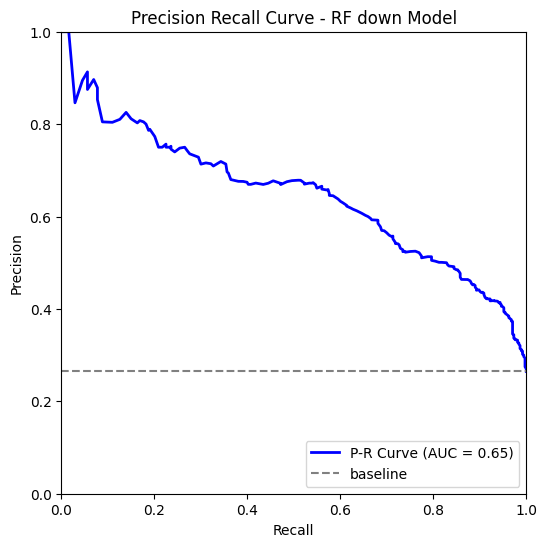

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'P-R Curve (AUC = {pr_auc:.2f})')

# baseline model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], color='gray', linestyle='--', label='baseline')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve - RF down Model')
plt.legend(loc="lower right")
plt.show()

* after 0.8 recall, precision drops drastically

## final model

In [28]:
rf_down_final = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_samples': [0.25, 0.5, 0.75],
}

final_gscv = GridSearchCV(rf_down_final, param_grid, cv=5, scoring='recall')
final_gscv.fit(X_train_down, y_train_down)

print(f"best recall: {final_gscv.best_score_:.2f}")
print(f"best params: {final_gscv.best_params_}")

best recall: 0.80
best params: {'max_depth': 5, 'max_samples': 0.5, 'n_estimators': 100}


In [45]:
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

LogisticRegression()

In [33]:
final_model = RandomForestClassifier(max_depth=5, max_samples=0.75, n_estimators=100)
final_model.fit(X_train_down, y_train_down)

RandomForestClassifier(max_depth=5, max_samples=0.75)

In [34]:
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.52      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.75      0.77      1409



In [46]:
base_model_accuracy = accuracy_score(y_test, base_model.predict(X_test))
final_model_accuracy = accuracy_score(y_test, final_model.predict(X_test))
accuracy_improvement = (final_model_accuracy - base_model_accuracy) / base_model_accuracy * 100
print(f"Accuracy improvement: {accuracy_improvement:.2f}%")

base_model_recall = recall_score(y_test, base_model.predict(X_test))
final_model_recall = recall_score(y_test, final_model.predict(X_test))
recall_improvement = (final_model_recall - base_model_recall) / base_model_recall * 100
print(f"Recall improvement: {recall_improvement:.2f}%")

Accuracy improvement: -8.38%
Recall improvement: 39.46%


In [47]:
threshold = 0.45
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_pred_proba >= threshold).astype(int)

final_model_accuracy = accuracy_score(y_test, y_pred_threshold)
accuracy_improvement = (final_model_accuracy - base_model_accuracy) / base_model_accuracy * 100
print(f"Accuracy improvement: {accuracy_improvement:.2f}%")

base_model_recall = recall_score(y_test, rf.predict(X_test))
final_model_recall = recall_score(y_test, y_pred_threshold)
recall_improvement = (final_model_recall - base_model_recall) / base_model_recall * 100
print(f"Recall improvement: {recall_improvement:.2f}%")

Accuracy improvement: -14.26%
Recall improvement: 47.98%


In [53]:
threshold = 0.44
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
y_pred_threshold = (y_pred_proba >= threshold).astype(int)

final_model_accuracy = accuracy_score(y_test, y_pred_threshold)
accuracy_improvement = (final_model_accuracy - base_model_accuracy) / base_model_accuracy * 100
print(f"Accuracy improvement: {accuracy_improvement:.2f}%")

base_model_recall = recall_score(y_test, rf.predict(X_test))
final_model_recall = recall_score(y_test, y_pred_threshold)
recall_improvement = (final_model_recall - base_model_recall) / base_model_recall * 100
print(f"Recall improvement: {recall_improvement:.2f}%")

Accuracy improvement: -14.35%
Recall improvement: 50.22%


# 6. Save Model

In [55]:
with open("preprocessor.pkl", "wb") as f:
  pickle.dump(preprocessor, f)

In [54]:
with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(final_model, f)

# 7. Load Model

In [111]:
with open("preprocessor.pkl", "rb") as f:
  loaded_preprocessor = pickle.load(f)

In [112]:
loaded_preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['gender', 'SeniorCitizen', 'Partner',
                                  'Dependents', 'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

In [113]:
with open("customer_churn_model.pkl", "rb") as f:
  loaded_model = pickle.load(f)

In [114]:
loaded_model

RandomForestClassifier(max_depth=5, max_samples=0.75)

In [132]:
input_data = {
    'customerID': '2131231232',
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 75.65,
    'TotalCharges': 900
}

input_data_df = pd.DataFrame([input_data])
input_data_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,2131231232,Female,0,Yes,No,12,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,75.65,900


In [133]:
input_data_df.drop('customerID', axis=1, inplace=True)
input_data_df['SeniorCitizen'] = input_data_df['SeniorCitizen'].astype(object)
input_data_df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,12,Yes,No,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,75.65,900


In [134]:
input_data_trf = loaded_preprocessor.transform(input_data_df)
input_data_trf

array([[-0.83419795,  0.35848943, -0.61294289,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ]])

In [136]:
sample_pred = loaded_model.predict(input_data_trf)
sample_pred

array([1])